In [1]:
# Import all the needed libraries
import pyterrier as pt
import pandas as pd
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import algos
import os
if not pt.started():
    pt.init()

PyTerrier 0.8.0 has loaded Terrier 5.6 (built by craigmacdonald on 2021-09-17 13:27)



In [2]:
# Load the dataset
dataset = pt.datasets.get_dataset("trec-deep-learning-passages")

In [3]:
# Create index reference bases on locally stored index files 
index_ref = pt.IndexRef.of(os.getcwd() + "./passage_index/data.properties")

In [4]:
# Create an index factory
index = pt.IndexFactory.of(index_ref)

18:33:42.541 [main] WARN org.terrier.structures.BaseCompressingMetaIndex - Structure meta reading data file directly from disk (SLOW) - try index.meta.data-source=fileinmem in the index properties file. 1,9 GiB of memory would be required.


In [5]:
# Print the statistics of the index
print(index.getCollectionStatistics().toString())

Number of documents: 8841823
Number of terms: 1170682
Number of postings: 215238456
Number of fields: 1
Number of tokens: 288759529
Field names: [text]
Positions:   false



In [6]:
# Create the batch retrieval model of the BM25, with the provided index for the passeges
bm25 = pt.BatchRetrieve(index, wmodel="BM25")

In [7]:
# Load the qrels
qrels = dataset.get_qrels("test-2019")
# Get all the scores for each query for each document in the test data collection
res = algos.get_all_scores(dataset, bm25)

18:33:42.686 [main] WARN org.terrier.applications.batchquerying.TRECQuery - trec.encoding is not set; resorting to platform default (windows-1252). Retrieval may be platform dependent. Recommend trec.encoding=UTF-8


In [8]:
# How well does BM25 perform on the test dataset, these are unseen examples
# Calcuclate the ndcg, map and mrr as evaluation metric
pt.Experiment(
  [bm25],
  dataset.get_topics("test-2019"), 
  dataset.get_qrels("test-2019"),
  eval_metrics=["ndcg", "map", "recip_rank"], 
  round=3,
)

18:34:23.118 [main] WARN org.terrier.applications.batchquerying.TRECQuery - trec.encoding is not set; resorting to platform default (windows-1252). Retrieval may be platform dependent. Recommend trec.encoding=UTF-8


,name,ndcg,map,recip_rank
0,BR(BM25),0.593,0.37,0.795


In [9]:
eval = pt.Utils.evaluate(res, qrels, metrics = ["recip_rank"], perquery = True)

In [ ]:
# Only 43 queries with qrels available in the collection

In [135]:
# For all the queries in the test collection, for which the qrel is provided, give us the MRR
eval

defaultdict(dict,
            {'156493': {'recip_rank': 1.0},
             '1110199': {'recip_rank': 1.0},
             '1063750': {'recip_rank': 0.3333333333333333},
             '130510': {'recip_rank': 1.0},
             '489204': {'recip_rank': 1.0},
             '573724': {'recip_rank': 0.5},
             '168216': {'recip_rank': 1.0},
             '1133167': {'recip_rank': 1.0},
             '527433': {'recip_rank': 1.0},
             '1037798': {'recip_rank': 0.3333333333333333},
             '915593': {'recip_rank': 1.0},
             '264014': {'recip_rank': 0.5},
             '1121402': {'recip_rank': 1.0},
             '962179': {'recip_rank': 0.025},
             '1117099': {'recip_rank': 1.0},
             '148538': {'recip_rank': 0.2},
             '451602': {'recip_rank': 0.3333333333333333},
             '359349': {'recip_rank': 1.0},
             '1115776': {'recip_rank': 1.0},
             '1112341': {'recip_rank': 1.0},
             '131843': {'recip_rank': 1.0},
   

In [136]:
# we need for each query id the most relevant document, and the recip procal rank and the query itself
# [[qid], [RR], [query]]

In [138]:
# Given the qids for the queries in the last section, we want now to retrieve these queries (text)
qids = [i for i in eval]
RR = [eval[j]['recip_rank'] for j in eval]

info = []
    
for qid in qids:
    info.append(str(res[res['qid']==str(qid)].iloc[0]["query"]))
                
# print(info)

['do goldfish grow', 'what is wifi vs bluetooth', 'why did the us volunterilay enter ww1', 'definition declaratory judgment', 'right pelvic pain causes', 'what are the social determinants of health', 'does legionella pneumophila cause pneumonia', 'how is the weather in jamaica', 'types of dysarthria from cerebral palsy', 'who is robert gray', 'what types of food can you cook sous vide', 'how long is life cycle of flea', 'what can contour plowing reduce', 'when was the salvation army founded', 'what is a active margin', 'difference between rn and bsn', 'medicare s definition of mechanical ventilation', 'how to find the midsegment of a trapezoid', 'what is an aml surveillance analyst', 'what is the daily life of thai people', 'definition of a sigmet', 'cost of interior concrete flooring', 'what is the most popular food in switzerland', 'how are some sharks warm blooded', 'what is durable medical equipment consist of', 'exons definition biology', 'define visceral', 'tracheids are part of'

In [139]:
queries = pd.DataFrame({"qid":qids,"mrr":RR,"query":info})

In [ ]:
# For each of these queries we want to retrieve the best ranked document (meaning the document with the highest relevancy)

In [145]:
# Return the top-1 ranked document for all queries in the test set
import gc
def get_topRanked_doc(queries, index_ref):
    docs = []
    for query in list(queries['query']):
        df = pt.BatchRetrieve(index_ref).search(query)[0:1]
        doc = (algos.search_with_doc_id(int(df['docid'])))
        docs.append(len(doc.split()))
        gc.collect()
    return docs

In [146]:
docs_lengths = get_topRanked_doc(queries, index_ref)
query_lengths = [len(query.split()) for query in list(queries['query'])]

20:30:53.701 [main] WARN org.terrier.structures.BaseCompressingMetaIndex - Structure meta reading data file directly from disk (SLOW) - try index.meta.data-source=fileinmem in the index properties file. 1,9 GiB of memory would be required.
20:31:05.146 [main] WARN org.terrier.structures.BaseCompressingMetaIndex - Structure meta reading data file directly from disk (SLOW) - try index.meta.data-source=fileinmem in the index properties file. 1,9 GiB of memory would be required.
20:31:17.043 [main] WARN org.terrier.structures.BaseCompressingMetaIndex - Structure meta reading data file directly from disk (SLOW) - try index.meta.data-source=fileinmem in the index properties file. 1,9 GiB of memory would be required.
20:31:23.720 [main] WARN org.terrier.structures.BaseCompressingMetaIndex - Structure meta reading data file directly from disk (SLOW) - try index.meta.data-source=fileinmem in the index properties file. 1,9 GiB of memory would be required.
20:31:26.926 [main] WARN org.terrier.str

In [147]:
queries['doc_length'] = docs_lengths
queries['query_length'] = query_lengths

In [148]:
# We now have a dataframe with the queries, their score, qid, passage length and query length
queries

,qid,mrr,query,doc_length,query_length
21,104861,1.000000,cost of interior concrete flooring,109,5
22,833860,1.000000,what is the most popular food in switzerland,90,8
23,207786,1.000000,how are some sharks warm blooded,128,6
24,1114819,1.000000,what is durable medical equipment consist of,132,7
25,183378,1.000000,exons definition biology,89,3
26,1106007,1.000000,define visceral,106,2
27,1124210,1.000000,tracheids are part of,86,4
28,490595,0.500000,rsa definition key,79,3
29,1103812,1.000000,who formed the commonwealth of independent states,112,7
30,87181,1.000000,causes of left ventricular hypertrophy,49,5


In [149]:
queries.to_csv("test_queries_with_info.csv",index=False)

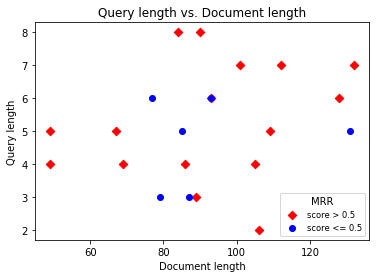

In [150]:
plt.scatter(x = queries[queries["mrr"]>0.5]["doc_length"], y = queries[queries["mrr"]>0.5]["query_length"],
           marker='D',
           color='red',
           label='score > 0.5')
plt.scatter(x =  queries[queries["mrr"]<=0.5]["doc_length"], y = queries[queries["mrr"]<=0.5]["query_length"] ,
           marker='o',
           color='blue',
           label='score <= 0.5')
plt.title('Query length vs. Document length')
plt.xlabel('Document length')
plt.ylabel('Query length')
plt.legend(title="MRR", loc=4, fontsize='small', fancybox=True)
plt.show()

In [151]:
# We assumed that longer query, we also assumed that the MRR would be higher but that does not seem the case

In [152]:
df1 = pd.read_csv("Query20WithLengths.csv")

In [153]:
frames = [df1, queries]
result = pd.concat(frames)
result

,qid,mrr,query,doc_length,query_length
0,156493,1.000000,do goldfish grow,90,3
1,1110199,1.000000,what is wifi vs bluetooth,96,5
2,1063750,0.333333,why did the us volunterilay enter ww1,100,7
3,130510,1.000000,definition declaratory judgment,54,3
4,489204,1.000000,right pelvic pain causes,50,4
5,573724,0.500000,what are the social determinants of health,83,7
6,168216,1.000000,does legionella pneumophila cause pneumonia,92,5
7,1133167,1.000000,how is the weather in jamaica,101,6
8,527433,1.000000,types of dysarthria from cerebral palsy,37,6
9,1037798,0.333333,who is robert gray,90,4


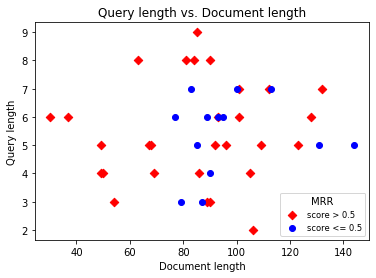

In [154]:
plt.scatter(x = result[result["mrr"]>0.5]["doc_length"], y = result[result["mrr"]>0.5]["query_length"],
           marker='D',
           color='red',
           label='score > 0.5')
plt.scatter(x =  result[result["mrr"]<=0.5]["doc_length"], y = result[result["mrr"]<=0.5]["query_length"] ,
           marker='o',
           color='blue',
           label='score <= 0.5')
plt.title('Query length vs. Document length')
plt.xlabel('Document length')
plt.ylabel('Query length')
plt.legend(title="MRR", loc=4, fontsize='small', fancybox=True)
plt.savefig('QueryLengthVSDocumentLength.svg')

In [155]:
result.to_csv("QueriesAllLengths.csv",index=False)

In [156]:
result = pd.read_csv("QueriesAllLengths.csv")

In [157]:
score = []
for qid in list(result["qid"]):
    df1 = res[(res["qid"]==str(qid)) & (res["rank"]==0)]
    score.append(float(df1["score"]))
result["score"] = score

In [158]:
result.to_csv("QueriesAllLengthScore.csv", index=False)

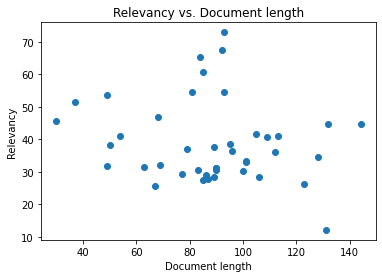

In [159]:
plt.scatter(result['doc_length'], result['score'])
plt.title('Relevancy vs. Document length')
plt.xlabel('Document length')
plt.ylabel('Relevancy')
plt.savefig('DocumentVsRelvancy.svg')
plt.show()

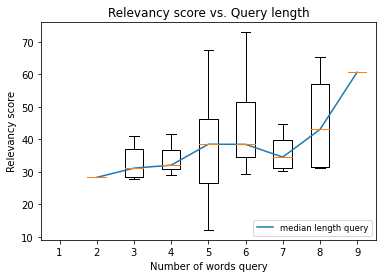

In [225]:
import numpy as np
import statistics

lists = [list(result[result['query_length']==idx]['score']) for idx in range(1,10)]

plt.boxplot(lists)

plt.plot(range(2,10), [statistics.median(x) for x in lists[1:9]], label='median length query')

plt.title('Relevancy score vs. Query length')
plt.xlabel('Number of words query')
plt.ylabel('Relevancy score')
plt.legend(loc=4, fontsize='small', fancybox=True)
plt.savefig('QueryVsRelvancy.svg')
plt.show()

In [168]:
####################################################################################################################
#####WHAT IS THE RESON THAT QUERIES FOR WHICH THE QREL IS PROVIDED, NO DOCUMENTS ARE RETRIEVED IN THE TOP1000?######
####################################################################################################################

In [117]:
import gc
#def given qrels dataset, return if qid, docid exists in ranked model
def check_qrel_queries():
    temp1 = dataset.get_topicsqrels("train")[0]
    queries_df = temp1.sort_values(by=['qid']).head(1000)
    temp2 = dataset.get_topicsqrels("train")[1]
    qrels_df = temp2.sort_values(by=['qid']).head(1000)
    
    docs_qrels = pd.DataFrame(columns =['rank','docid','score','qid'])

    for qid in list(queries_df["qid"]):
        # One particular query
        qrels_queries = qrels_df[qrels_df["qid"] == qid]
        
        if len(qrels_queries) == 0:
            # print("qid:" + str(qid) + "does not exist")
            continue
            
        docNo = qrels_queries.iloc[0]["docno"]        
        query = queries_df[queries_df["qid"] == qid].iloc[0]["query"]
        
        # Returns the top 1000 relevant documents for this query (that has as qrel)
        result = bm25.search(query)
        
        docs_qrels = docs_qrels.append(check_rel_doc_present(docNo, qid, query, result), ignore_index=True)
        
        del result
        del qrels_queries
        gc.collect()
        
    
    return docs_qrels

#given a docid, search if the doc id exists in result.
def check_rel_doc_present(docid, qid, query, result):

    # Hypothesis that this if statement is always true
    if docid in list(result["docno"]):
        R = result[result["docno"]==docid]
        rank = R.iloc[0]["rank"]
        score = R.iloc[0]["score"]
        doc_id = R.iloc[0]["docid"]
        # print("rank : ", rank)
        # print("score: ", score)
        # print("docid : ", doc_id)
        return {"rank":rank, "docid":doc_id, "score":round(score,2), "qid":qid, "query":query}
    else:
        # Then we have document that were not found in the top-1000 ranked documents despite 
        # the query they belong to had a qrel provided
        
        # print("not found")
        return {"rank":-1, "docid":docid, "score":-1, "qid":qid, "query":query}

In [118]:
temp = check_qrel_queries()

19:25:27.374 [main] WARN org.terrier.applications.batchquerying.TRECQuery - trec.encoding is not set; resorting to platform default (windows-1252). Retrieval may be platform dependent. Recommend trec.encoding=UTF-8
19:25:42.673 [main] WARN org.terrier.applications.batchquerying.TRECQuery - trec.encoding is not set; resorting to platform default (windows-1252). Retrieval may be platform dependent. Recommend trec.encoding=UTF-8


In [119]:
temp

,rank,docid,score,qid,query
0,2,3837260,41.86,100,of earths crust is dysprosium
1,3,1936056,55.86,10000,about what proportion of quebec s population s...
2,190,3617179,17.54,1000005,where is westminster california
3,38,5939245,20.03,1000007,where is westminster ma
4,0,4630854,31.57,1000008,where is westminster md
...,...,...,...,...,...
686,998,2011677,16.78,100125,cortana who are the forerunners
687,94,5714439,21.75,100126,cortana who is arbiter
688,-1,4670229,-1.00,1001260,where to buy make up from accessorize uk
689,2,4402712,68.32,1001262,where to buy maui jim prescription sunglasses


In [121]:
temp.to_csv("QUERIES_W_QRESL_RETRIEVED_AND_NOT_RETRIEVED.csv", index=False)

In [112]:
# Now we are going to sort the queries bases on their rank aka if rank == -1 we are putting those in a new dataframe

In [113]:
DOCS = pd.read_csv("./collection.tsv", sep='\t', header=1, names=["passage"])


In [114]:
DOCS

,passage
2,Essay on The Manhattan Project - The Manhattan...
3,The Manhattan Project was the name for a proje...
4,versions of each volume as well as complementa...
5,The Manhattan Project. This once classified ph...
6,Nor will it attempt to substitute for the extr...
...,...
8841818,When metal salts emit short wavelengths of vis...
8841819,Thousands of people across the United States w...
8841820,"The recipe that creates blue, for example, inc..."
8841821,"On Independence Days of yore, old-timey crowds..."


In [122]:
queries_without_doc_retrieved = temp[temp['score']==(-1.00)]
# THESE ARE THE QUERIES FOR WHICH A QREL IS PROVIDED, BUT THE MODEL DID NOT RETRIEVE A DOCUMENT (WAS NOT IN THE 
# TOP 1000)

In [123]:
queries_without_doc_retrieved = queries_without_doc_retrieved.head(10)

In [124]:
queries_without_doc_retrieved

,rank,docid,score,qid,query
29,-1,2640014,-1.0,1000041,where is wheat grown mainly state
36,-1,4496957,-1.0,1000052,where is whip coral harvested
53,-1,4660814,-1.0,1000089,where is whitehall kentucky
60,-1,3943327,-1.0,100010,cortana what is polygamy
94,-1,3035531,-1.0,100015,cortana what is the average blood pressure
128,-1,2441538,-1.0,1000204,where is wilson co tn county seat
130,-1,3797484,-1.0,1000207,where is wilson nc
140,-1,2964624,-1.0,100022,cortana what is the definition of love
143,-1,4393147,-1.0,1000226,where is windows program located
151,-1,2372474,-1.0,100024,cortana what is the do carrots


In [125]:
# RETRIEVE THESE DOCUMENTS TO SEE WHAT IS WRONG
passages = [(DOCS.iloc[(int(x) - 1)]['passage']) for x in queries_without_doc_retrieved['docid']]

In [126]:
queries_without_doc_retrieved['passages'] = passages

In [127]:
# FOR THOSE QUERIES WITH A QREL, NOW THE PASSAGES ARE FOUND BY US IN THE DOCUMENT AND ATTACHED
queries_without_doc_retrieved

,rank,docid,score,qid,query,passages
29,-1,2640014,-1.0,1000041,where is wheat grown mainly state,"Punjab, Haryana, Uttar Pradesh, Rajasthan and ..."
36,-1,4496957,-1.0,1000052,where is whip coral harvested,"Clearly, this is an important field of study f..."
53,-1,4660814,-1.0,1000089,where is whitehall kentucky,Jupiter's moons. Each of the gas giant planets...
60,-1,3943327,-1.0,100010,cortana what is polygamy,Recent Examples of polygamy from the Web. 1 B...
94,-1,3035531,-1.0,100015,cortana what is the average blood pressure,"Ideally, we should all have a blood pressure b..."
128,-1,2441538,-1.0,1000204,where is wilson co tn county seat,Written by: Amelia Morrison Hipps September 10...
130,-1,3797484,-1.0,1000207,where is wilson nc,There could not be a better start for my unive...
140,-1,2964624,-1.0,100022,cortana what is the definition of love,Examples of jones in a sentence. 1 that dude ...
143,-1,4393147,-1.0,1000226,where is windows program located,"To open the certain program folder, -path pres..."
151,-1,2372474,-1.0,100024,cortana what is the do carrots,Not all of the chemical constituents of carrot...


In [ ]:
queries_without_doc_retrieved[queries_without_doc_retrieved['qid'] == str(1000041)]['passages']

In [128]:
queries_without_doc_retrieved.to_csv("QUERIES_WITHOUT_DOC_IN_RETRIEVAL_WITHQREL.csv", index=False)

In [ ]:
# Model built with all the queries (regardless of they have qrels), and evaluation is where we are using 
# the qrels to determine the relevancy (intstrument to give the final score)

# Given the query, with its qrel, these documents were not retrieved.
# So either the query is wrong or the less likely case is that the qrel is wrong
# Assuming the query is wrong, possibilities that causes the system to malfunctio the system is because...
# - Perhaps the document is not classified as relevant because either the query or the passage using synomyms 

In [ ]:
# ERROR ANALYSIS - BM25 - ALL
# - (WIP)Julian: Need to determine for which queries (with qrel) the document is not retrived?
#   - And provided reasons for this
# - (WIP/DONE)Julian:Least performing queries (with qrels), provide the best performing documents,
#    what can we say about them?
# - (see Google docs for extra is time allows)
# IMPROVEMENTS - BM25 (ask the teacher if we need to do error analysis on these as well? - nice to have)
# - Julian : Query expansion 
# - Varnika + Monice : error analysis
# - All : SIGNIFICANCE TESTING BETWEEN BM25 AND IMPROVEMENTS (see Pyterrier)
#---------------------------------------------------------------------------------------------------------------------
# Julian : INDEXING L2R
# - WIP
# Julian : IMPLEMENTING BASELINE (L2R)
# - WIP
# (maybe verify with the teacher just to be sure that this is everything that needs to be done)
#---------------------------------------------------------------------------------------------------------------------
# REPORT (All)
# - Update the report according to the feedback we receive from the teacher/TA
# - Extend the report where needed
#---------------------------------------------------------------------------------------------------------------------
# STUDY!
# - Queations about the prodcut, reason why we did something instead of something else
# - Or ask questions about theory of the course, and why we choose to use BM25 instead of other model
#---------------------------------------------------------------------------------------------------------------------
# (DONE)Julian : send email Claudi + GitHub
# - Should do the error analysis also on the improvements similar to what we had for the baseline BM25?
# - Do the images count towards the page limit?
#---------------------------------------------------------------------------------------------------------------------
# Next meeting either Thursday or Friday